# AirBnb Seattle

### Preparing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
import seaborn as sns
from ipyleaflet import Map, Marker, MarkerCluster
import folium
from folium.plugins import FastMarkerCluster
import sqlalchemy as db
import subprocess
import pymysql
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sqlalchemy.exc import IntegrityError

import os
import time
import datetime
import pipes
# Veuillez entrer le répertoire où se trouvent les datasets dans la variable suivante.
dataset_repertory = "/content/drive/My Drive/Dataset/"
    
plt.style.use('seaborn-dark')
plt.rcParams["figure.figsize"] = (14,4)

In [2]:
reviews = pd.read_csv("/home/arcanum/Téléchargements/TP/Python/CSV/reviews.csv.gz",
                      compression="gzip", low_memory=False)

planning = pd.read_csv("/home/arcanum/Téléchargements/TP/Python/CSV/calendar.csv.gz",
                       compression="gzip", low_memory=False)

listingss = pd.read_csv("/home/arcanum/Téléchargements/TP/Python/CSV/listings.csv.gz",
                        compression="gzip", low_memory=False)

In [6]:
reviews = pd.read_csv("http://data.insideairbnb.com/united-states/wa/seattle/@Value(_timestamp)/data/reviews.csv.gz", compression="gzip", low_memory=False)
planning = pd.read_csv("http://data.insideairbnb.com/united-states/wa/seattle/@Value(_timestamp)/data/calendar.csv.gz", compression="gzip", low_memory=False)
listings = pd.read_csv("http://data.insideairbnb.com/united-states/wa/seattle/@Value(_timestamp)/data/listings.csv.gz", compression="gzip", low_memory=False)

HTTPError: HTTP Error 404: Not Found

In [8]:
listingss['square_feet']

0          NaN
1          NaN
2        200.0
3       1200.0
4          NaN
         ...  
7012       NaN
7013       NaN
7014       NaN
7015       NaN
7016       NaN
Name: square_feet, Length: 7017, dtype: float64

# Gestion des valeurs nulls

In [3]:
listingss.isna().sum()

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
name                                              0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               941
Length: 106, dtype: int64

In [4]:
nan = listingss['reviews_per_month'].isna().value_counts()
nan

False    6076
True      941
Name: reviews_per_month, dtype: int64

In [5]:
listings = listingss.fillna(0)

In [6]:
listings["host_id"].unique()

array([     2536,     14942,     30559, ..., 299537650, 346462113,
        38039897])

In [7]:
host_2536 = listingss[listingss['host_id'] == 2536]
host_2536[['host_id', 'host_name', 'host_since', 'listing_url']]

host_id host_name  host_since                            listing_url
0        2536     Megan  2008-08-26      https://www.airbnb.com/rooms/2318
4702     2536     Megan  2008-08-26  https://www.airbnb.com/rooms/30013204

In [8]:
listings.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7012    False
7013    False
7014    False
7015    False
7016    False
Length: 7017, dtype: bool

In [9]:
# host
host = pd.DataFrame(listings[["host_id","host_since","host_name"]])
 
# property
properties = pd.DataFrame(listings[["accommodates","bathrooms","bedrooms","beds","bed_type","room_type","square_feet","longitude","latitude"]])

# location
location = pd.DataFrame(listings[["street","state","country","zipcode","neighborhood_overview","neighbourhood_cleansed","city"]])

#price
prices = pd.DataFrame(listings[["price","weekly_price","monthly_price"]])

# listing
listing = pd.DataFrame(listings[["id","name","description","summary","notes"]])
listing.rename(columns={'name':'l_name','description':'l_description'},inplace=True)

#calendar
calendar = planning.rename(columns={'date':'p_date'}, inplace=True)

In [10]:
host.isna().sum()

host_id       0
host_since    0
host_name     0
dtype: int64

# Connexion 

In [17]:
from sqlalchemy import create_engine
import pymysql

db_connection_str = 'mysql+pymysql://root:Vazapoto85@@localhost/sairbnb'
db_connection = create_engine(db_connection_str)

#df = pd.read_sql('SELECT * FROM table_name', con=db_connection)

# Chargement des tables

In [17]:
#host
for i in range(len(host)):
    try:
        host.iloc[i:i+1].to_sql(name='hoste', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action

#properties
for i in range(len(properties)):
    try:
        properties.iloc[i:i+1].to_sql(name='property', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action
    
#listing    
for i in range(len(listing)):
    try:
        listing.iloc[i:i+1].to_sql(name='listing', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action
    
#location
for i in range(len(location)):
    try:
        location.iloc[i:i+1].to_sql(name='location', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action
    
    
#price
for i in range(len(price)):
    try:
        price.iloc[i:i+1].to_sql(name='price', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action
    

InternalError: (pymysql.err.InternalError) (1366, "Incorrect integer value: 'Please treat the cottage as if it were your own, comfortably and carefully.  Energy conservative habits expected please. Rinse a' for column 'house_rules' at row 1")
[SQL: INSERT INTO listing (id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, has_availability, availability_30, availability_60, availability_90, availability_365, calendar_last_scraped, number_of_reviews, number_of_reviews_ltm, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, requires_license, license, jurisdiction_names, instant_bookable, is_business_travel_ready, cancellation_policy, require_guest_profile_picture, require_guest_phone_verification, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month) VALUES (%(id)s, %(listing_url)s, %(scrape_id)s, %(last_scraped)s, %(name)s, %(summary)s, %(space)s, %(description)s, %(experiences_offered)s, %(neighborhood_overview)s, %(notes)s, %(transit)s, %(access)s, %(interaction)s, %(house_rules)s, %(thumbnail_url)s, %(medium_url)s, %(picture_url)s, %(xl_picture_url)s, %(host_id)s, %(host_url)s, %(host_name)s, %(host_since)s, %(host_location)s, %(host_about)s, %(host_response_time)s, %(host_response_rate)s, %(host_acceptance_rate)s, %(host_is_superhost)s, %(host_thumbnail_url)s, %(host_picture_url)s, %(host_neighbourhood)s, %(host_listings_count)s, %(host_total_listings_count)s, %(host_verifications)s, %(host_has_profile_pic)s, %(host_identity_verified)s, %(street)s, %(neighbourhood)s, %(neighbourhood_cleansed)s, %(neighbourhood_group_cleansed)s, %(city)s, %(state)s, %(zipcode)s, %(market)s, %(smart_location)s, %(country_code)s, %(country)s, %(latitude)s, %(longitude)s, %(is_location_exact)s, %(property_type)s, %(room_type)s, %(accommodates)s, %(bathrooms)s, %(bedrooms)s, %(beds)s, %(bed_type)s, %(amenities)s, %(square_feet)s, %(price)s, %(weekly_price)s, %(monthly_price)s, %(security_deposit)s, %(cleaning_fee)s, %(guests_included)s, %(extra_people)s, %(minimum_nights)s, %(maximum_nights)s, %(minimum_minimum_nights)s, %(maximum_minimum_nights)s, %(minimum_maximum_nights)s, %(maximum_maximum_nights)s, %(minimum_nights_avg_ntm)s, %(maximum_nights_avg_ntm)s, %(calendar_updated)s, %(has_availability)s, %(availability_30)s, %(availability_60)s, %(availability_90)s, %(availability_365)s, %(calendar_last_scraped)s, %(number_of_reviews)s, %(number_of_reviews_ltm)s, %(first_review)s, %(last_review)s, %(review_scores_rating)s, %(review_scores_accuracy)s, %(review_scores_cleanliness)s, %(review_scores_checkin)s, %(review_scores_communication)s, %(review_scores_location)s, %(review_scores_value)s, %(requires_license)s, %(license)s, %(jurisdiction_names)s, %(instant_bookable)s, %(is_business_travel_ready)s, %(cancellation_policy)s, %(require_guest_profile_picture)s, %(require_guest_phone_verification)s, %(calculated_host_listings_count)s, %(calculated_host_listings_count_entire_homes)s, %(calculated_host_listings_count_private_rooms)s, %(calculated_host_listings_count_shared_rooms)s, %(reviews_per_month)s)]
[parameters: {'id': 6606, 'listing_url': 'https://www.airbnb.com/rooms/6606', 'scrape_id': 20200521035945, 'last_scraped': '2020-05-21', 'name': 'Fab, private seattle urban cottage!', 'summary': 'This tiny cottage is only 15x10, but it has everything you need..including a garden just outside!  Newer queen bed, down pillows/ duvet, tv, closet w ... (198 characters truncated) ... opean style   is across from kitchen separated by a TALL shower curtain.  Our walking score is 95, with 2 neighborhoods w/in a mile, buses on corner.', 'space': "Soo centrally located, this is a little house  all your own ! This cozy,charming cottage for two has cathedral ceilings,skylight, and a french door o ... (701 characters truncated) ... s easy free street parking too.new A/C,! (  cottage is not available monthly from may- october) Please read house rules before (URL HIDDEN) it suits!", 'description': "This tiny cottage is only 15x10, but it has everything you need..including a garden just outside!  Newer queen bed, down pillows/ duvet, tv, closet w ... (702 characters truncated) ... remodeled w/European style wet room,. kitchenette  across the way has a sink micro,toaster , hot plate and a half size fridge. You are ready for coff", 'experiences_offered': 'none', 'neighborhood_overview': "A peaceful yet highly accessible neighborhood, gardens galore.  The university district, Fremont, and wallingford are all walkable.( 5 Blocks from wallingford's business district.)", 'notes': "Check in is at three, if you'd like a snack or a bit of the neighborhood..  If I can help as a local resource, let me know.  I recommend Archie Mcfee ... (84 characters truncated) ... ay 44 n stone, 45th and stone.  There is always Gasworks park and the essential bakery for lunch ,34( both are walkable from the house) and woodlawn.", 'transit': 0, 'access': 0, 'interaction': 'I often escape to kingston and my place on the water.( which may be available to you!) I am always a text away, and can be back if urgent in an hour and a half.', 'house_rules': "Please treat the cottage as if it were your own, comfortably and carefully.  Energy conservative habits expected please. Rinse and crush recycling an ... (562 characters truncated) ... side guests.Please be Quiet after 9, as the neighbors children sleep  12 ft. away.please wear a suit! Hot tub off to conserve energy nov15 -march 15.", 'thumbnail_url': 0.0, 'medium_url': 0.0, 'picture_url': 'https://a0.muscache.com/im/pictures/45742/21116d7d_original.jpg?aki_policy=large', 'xl_picture_url': 0.0, 'host_id': 14942, 'host_url': 'https://www.airbnb.com/users/show/14942', 'host_name': 'Joyce', 'host_since': '2009-04-26', 'host_location': 'Seattle, Washington, United States', 'host_about': 'I am a therapist/innkeeper.I know my city well and am know as a fab concierge. I love art, the outdoors, books, music and dogs. \r\n fav activities? thrifting, museums, spending time at my yurt.', 'host_response_time': 'within an hour', 'host_response_rate': '100%', 'host_acceptance_rate': '92%', 'host_is_superhost': 'f', 'host_thumbnail_url': 'https://a0.muscache.com/im/users/14942/profile_pic/1308204367/original.jpg?aki_policy=profile_small', 'host_picture_url': 'https://a0.muscache.com/im/users/14942/profile_pic/1308204367/original.jpg?aki_policy=profile_x_medium', 'host_neighbourhood': 'Wallingford', 'host_listings_count': 5, 'host_total_listings_count': 5, 'host_verifications': "['email', 'phone', 'facebook', 'reviews', 'kba']", 'host_has_profile_pic': 't', 'host_identity_verified': 't', 'street': 'Seattle, WA, United States', 'neighbourhood': 'Wallingford', 'neighbourhood_cleansed': 'Wallingford', 'neighbourhood_group_cleansed': 'Other neighborhoods', 'city': 'Seattle', 'state': 'WA', 'zipcode': '98103', 'market': 'Seattle', 'smart_location': 'Seattle, WA', 'country_code': 'US', 'country': 'United States', 'latitude': 47.654109999999996, 'longitude': -122.33761000000001, 'is_location_exact': 't', 'property_type': 'Guesthouse', 'room_type': 'Entire home/apt', 'accommodates': 2, 'bathrooms': 1.0, 'bedrooms': 1.0, 'beds': 1.0, 'bed_type': 'Real Bed', 'amenities': '{TV,Internet,Wifi,"Air conditioning",Kitchen,"Free parking on premises",Heating,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essen ... (44 characters truncated) ... ir dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_50","Private entrance","Bed linens","Extra pillows and blankets"}', 'square_feet': 0.0, 'price': '$90.00', 'weekly_price': '$670.00', 'monthly_price': 0, 'security_deposit': '$200.00', 'cleaning_fee': '$40.00', 'guests_included': 2, 'extra_people': '$10.00', 'minimum_nights': 30, 'maximum_nights': 1125, 'minimum_minimum_nights': 30, 'maximum_minimum_nights': 30, 'minimum_maximum_nights': 1125, 'maximum_maximum_nights': 1125, 'minimum_nights_avg_ntm': 30.0, 'maximum_nights_avg_ntm': 1125.0, 'calendar_updated': '6 months ago', 'has_availability': 't', 'availability_30': 29, 'availability_60': 59, 'availability_90': 89, 'availability_365': 89, 'calendar_last_scraped': '2020-05-21', 'number_of_reviews': 150, 'number_of_reviews_ltm': 14, 'first_review': '2009-07-17', 'last_review': '2019-09-28', 'review_scores_rating': 92.0, 'review_scores_accuracy': 9.0, 'review_scores_cleanliness': 9.0, 'review_scores_checkin': 10.0, 'review_scores_communication': 10.0, 'review_scores_location': 10.0, 'review_scores_value': 9.0, 'requires_license': 't', 'license': 0, 'jurisdiction_names': '{WASHINGTON," Seattle"," WA"}', 'instant_bookable': 'f', 'is_business_travel_ready': 'f', 'cancellation_policy': 'strict_14_with_grace_period', 'require_guest_profile_picture': 'f', 'require_guest_phone_verification': 'f', 'calculated_host_listings_count': 3, 'calculated_host_listings_count_entire_homes': 3, 'calculated_host_listings_count_private_rooms': 0, 'calculated_host_listings_count_shared_rooms': 0, 'reviews_per_month': 1.14}]
(Background on this error at: http://sqlalche.me/e/2j85)

In [ ]:
#calendar
for i in range(len(planning)):
    try:
        planning.iloc[i:i+1].to_sql(name='calendar', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action

In [ ]:
#review
for i in range(len(reviews)):
    try:
        reviews.iloc[i:i+1].to_sql(name='review', con=db_connection, if_exists='append', index=False)
    except IntegrityError:
        pass #or any other action

# Quel est le prix moyen des locations air&b pour chaque ville || Dans quelle ville trouve-t-on les location airb&b les plus chers


In [18]:
Q1 = pd.read_sql('''Select AVG(cast(replace(price, "$", "") as double)) as AVG_Price, city 
                 FROM price 
                 JOIN location 
                 ON price_id = location_id 
                 group by city 
                 order by AVG_Price DESC LIMIT 1;''', 
                 con=db_connection)
Q1

AVG_Price              city
0      200.0  Lake Forest Park

# Est-ce que "review_score" varie en fonction du" room_type "


In [19]:
Q2 = pd.read_sql('''Select room_type,avg(review_scores_rating) as AVG_score,
                    max(review_scores_rating) as MAX_score,
                    min(review_scores_rating) as MIN_score,
                    count(review_scores_rating) as total 
                    from review 
                    Join location 
                    on reviewer_id = location_id 
                    join property 
                    on reviewer_id = property_id 
                    Group by room_type;''',
                 con=db_connection, index_col = ["room_type"])
Q2

AVG_score MAX_score MIN_score  total
room_type                                            
Entire home/apt   3.030303     100.0               33
Private room      7.692308     100.0               13
Shared room       0.000000                          1

# Combien d'hôtes rejoignent la plateforme airb&b chaque année

In [21]:
Q4 = pd.read_sql('''WITH subQ1 as (SELECT distinct host_id,YEAR(host_since) as Year_since
                 from hoste) select count(host_id) as total_host, year_since from subQ1 
                 group by Year_since order by Year_since DESC;''', con=db_connection)
Q4

total_host  year_since
0           22        2020
1          238        2019
2          265        2018
3          345        2017
4          630        2016
5          778        2015
6          708        2014
7          542        2013
8          384        2012
9          194        2011
10          60        2010
11          22        2009
12           3        2008

In [11]:
## Fermeture de la connexion MySQL une fois les tables stockées
dbconnection.close()

In [12]:
#list(listings.columns)

In [46]:
host_names = listingss['host_name'].dropna()
names = listingss['name'].dropna()
neighbourhood = listingss['neighbourhood']

In [47]:
def make_wordcloud(words):

    text = ""
    for word in words:
        text = text + " " + word

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords,colormap="plasma",width=1920, height=1080,max_font_size=200, max_words=200, background_color="white").generate(text)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation="gaussian")
    plt.axis("off")
    plt.show()

In [2]:
# Import required python libraries
# MySQL database details to which backup to be done. Make sure below user having enough privileges to take databases backup.
# To take multiple databases backup, create any file like /backup/dbnames.txt and put databases names one on each line and assigned to DB_NAME variable.

DB_HOST = 'localhost' 
DB_USER = 'root'
DB_USER_PASSWORD = 'Vazapoto85@'
#DB_NAME = '/backup/dbnameslist.txt'
DB_NAME = 'db_name_to_backup'
BACKUP_PATH = '/home/arcanum/projet_C_O/backup'

# Getting current DateTime to create the separate backup folder like "20180817-123433".
DATETIME = time.strftime('%Y%m%d-%H%M%S')
TODAYBACKUPPATH = BACKUP_PATH + '/' + DATETIME

# Checking if backup folder already exists or not. If not exists will create it.
try:
    os.stat(TODAYBACKUPPATH)
except:
    os.mkdir(TODAYBACKUPPATH)

# Code for checking if you want to take single database backup or assinged multiple backups in DB_NAME.
print ("checking for databases names file.")
if os.path.exists(DB_NAME):
    file1 = open(DB_NAME)
    multi = 1
    print ("Databases file found...")
    print ("Starting backup of all dbs listed in file " + DB_NAME)
else:
    print ("Databases file not found...")
    print ("Starting backup of database " + DB_NAME)
    multi = 0

# Starting actual database backup process.
if multi:
   in_file = open(DB_NAME,"r")
   flength = len(in_file.readlines())
   in_file.close()
   p = 1
   dbfile = open(DB_NAME,"r")

   while p <= flength:
       db = dbfile.readline()   # reading database name from file
       db = db[:-1]         # deletes extra line
       dumpcmd = "mysqldump -h " + DB_HOST + " -u " + DB_USER + " -p" + DB_USER_PASSWORD + " " + db + " > " + pipes.quote(TODAYBACKUPPATH) + "/" + db + ".sql"
       os.system(dumpcmd)
       gzipcmd = "gzip " + pipes.quote(TODAYBACKUPPATH) + "/" + db + ".sql"
       os.system(gzipcmd)
       p = p + 1
   dbfile.close()
else:
   db = DB_NAME
   dumpcmd = "mysqldump -h " + DB_HOST + " -u " + DB_USER + " -p" + DB_USER_PASSWORD + " " + db + " > " + pipes.quote(TODAYBACKUPPATH) + "/" + db + ".sql"
   os.system(dumpcmd)
   gzipcmd = "gzip " + pipes.quote(TODAYBACKUPPATH) + "/" + db + ".sql"
   os.system(gzipcmd)

print ("")
print ("Backup script completed")
print ("Your backups have been created in '" + TODAYBACKUPPATH + "' directory")

checking for databases names file.
Databases file not found...
Starting backup of database db_name_to_backup

Backup script completed
Your backups have been created in '/home/arcanum/projet_C_O/backup/20200624-223324' directory


In [ ]:
@monthly /scripts/script.sh

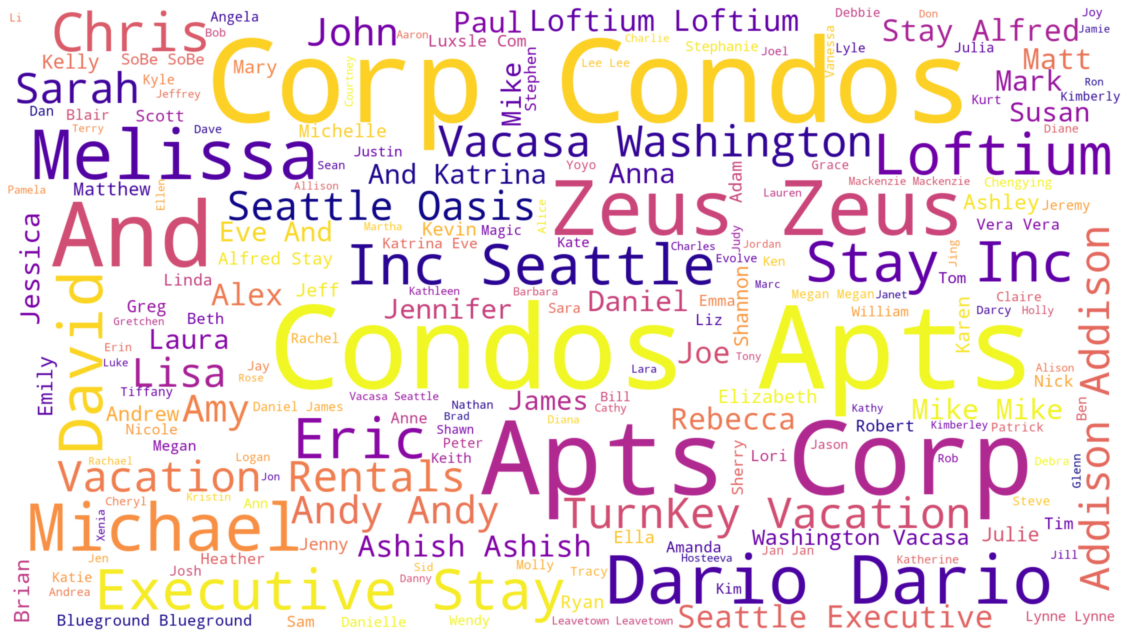

In [48]:
make_wordcloud(host_names)

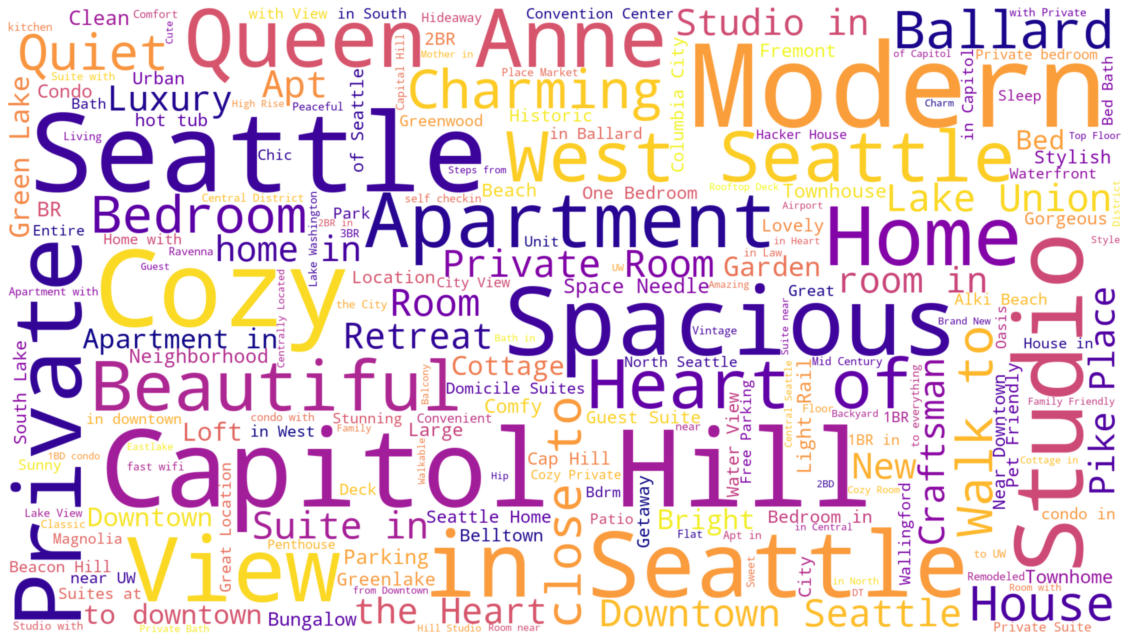

In [49]:
make_wordcloud(names)

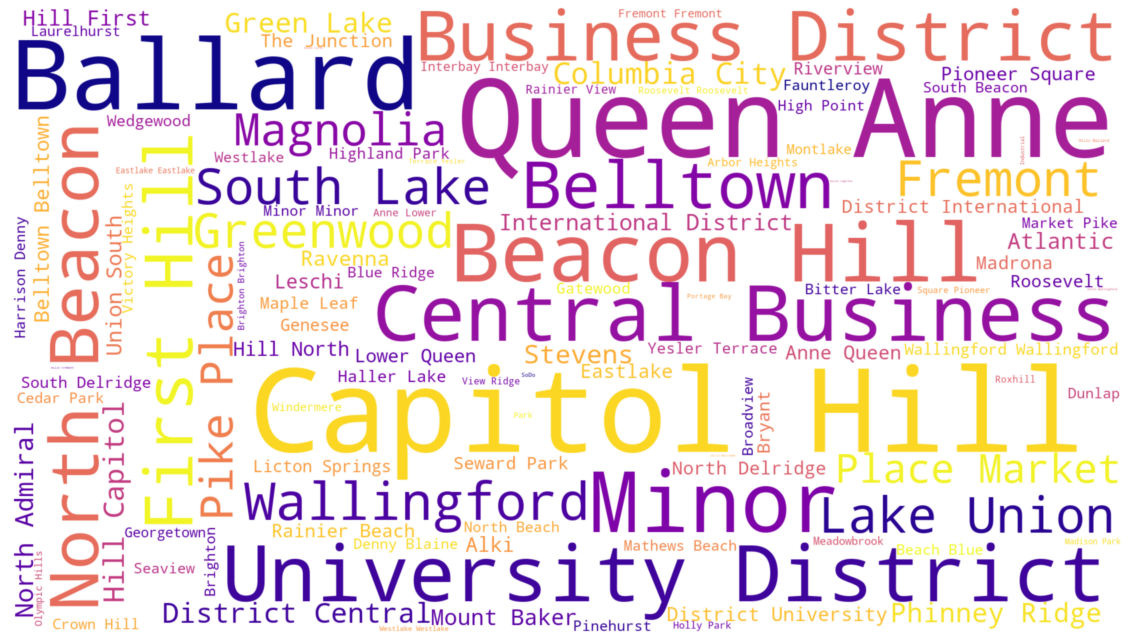

In [50]:
make_wordcloud(neighbourhood)

### 1.Neighbourhoods

In [ ]:
listings = pd.merge(listing, host, location, properties,price)

In [52]:
print("Il y a %i \"neighbourhood\" différents dans la base de données de AirBnb Seattle." %listingss.neighbourhood.nunique())

Il y a 79 "neighbourhood" différents dans la base de données de AirBnb Seattle.


Afin de représenter visuellement la distribution sous forme de barchart, nous avons besoin d'une division plus générale.

In [53]:
print("Il y a %i \"neighbourhood_cleansed\" différents dans la base de données de AirBnb Seattle." %listingss.neighbourhood_cleansed.nunique())

Il y a 88 "neighbourhood_cleansed" différents dans la base de données de AirBnb Seattle.


In [54]:
listingss.neighbourhood_cleansed.unique()

array(['Madrona', 'Wallingford', 'Georgetown', 'Fairmount Park',
       'Green Lake', 'Belltown', 'Adams', 'Whittier Heights', 'Broadway',
       'Loyal Heights', 'Mid-Beacon Hill', 'Windermere', 'West Woodland',
       'Seward Park', 'Alki', 'Stevens', 'North Admiral', 'Fremont',
       'Harrison/Denny-Blaine', 'North Beacon Hill', 'Mann',
       'Portage Bay', 'Lower Queen Anne', 'Phinney Ridge', 'View Ridge',
       'Crown Hill', 'Columbia City', 'Lawton Park', 'Matthews Beach',
       'North Queen Anne', 'West Queen Anne', 'North Beach/Blue Ridge',
       'First Hill', 'Eastlake', 'Atlantic', 'Arbor Heights',
       'International District', 'Greenwood', 'Wedgwood', 'Sunset Hill',
       'Cedar Park', 'Pike-Market', 'Riverview', 'Mount Baker', 'Genesee',
       'Central Business District', 'Fauntleroy', 'Bryant',
       'University District', 'Minor', 'South Delridge', 'Broadview',
       'Maple Leaf', 'Leschi', 'Pioneer Square', 'Ravenna',
       'Highland Park', 'Brighton', 'Mont

Cette division semble optimale pour notre objectif.

In [50]:
listings.neighbourhood_cleansed.isna().sum()

0

De plus, cette division n'a aucune valeur null.

In [51]:
listings.groupby("neighbourhood_cleansed").id.count().sort_values(ascending = False)

neighbourhood_cleansed
Broadway                     413
Belltown                     405
Wallingford                  280
Central Business District    264
University District          243
                            ... 
View Ridge                    13
South Park                     9
Holly Park                     4
Industrial District            3
Harbor Island                  1
Name: id, Length: 89, dtype: int64

In [11]:
#grp = listings.groupby("neighbourhood").id.count().sort_values(ascending=True)
#plt.figure(figsize=(22,18)) 
#plt.barh(grp.index, grp )
#plt.grid()
#plt.title("Nombre de logements AirBnb dans chaque quartier")
#plt.show()

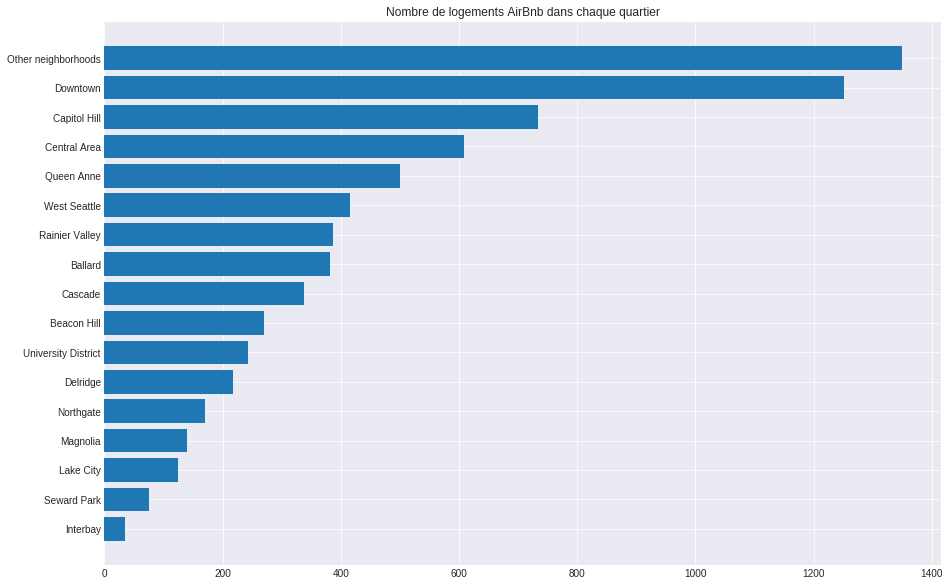

In [53]:
grp = listings.groupby("neighbourhood_group_cleansed").id.count().sort_values(ascending=True)
plt.figure(figsize=(15,10)) 
plt.barh(grp.index, grp )
plt.grid()
plt.title("Nombre de logements AirBnb dans chaque quartier")
plt.show()

In [54]:
listings.neighbourhood_cleansed

0                         Madrona
1                     Wallingford
2                      Georgetown
3                  Fairmount Park
4                  Fairmount Park
                  ...            
7232    Central Business District
7233                  Pike-Market
7234                  Pike-Market
7235                        Adams
7236               South Delridge
Name: neighbourhood_cleansed, Length: 7237, dtype: object

### 2. Property types

In [57]:
prop = listings.groupby(["property_type","room_type"]).id.count().unstack()

In [58]:
prop.fillna(0, inplace=True)
prop

room_type           Entire home/apt  Hotel room  Private room  Shared room
property_type                                                             
Aparthotel                      8.0         1.0           0.0          0.0
Apartment                    2005.0         0.0         116.0         13.0
Bed and breakfast               1.0         1.0          11.0          1.0
Boat                           14.0         0.0           1.0          0.0
Boutique hotel                  3.0         1.0          60.0          0.0
Bungalow                       52.0         0.0          16.0          0.0
Cabin                          11.0         0.0           0.0          0.0
Camper/RV                       8.0         0.0           2.0          0.0
Chalet                          1.0         0.0           0.0          0.0
Condominium                   423.0         0.0          28.0          3.0
Cottage                        46.0         0.0           7.0          0.0
Dome house                      0.0         0.0           7.0          0.0
Earth house                     1.0         0.0           1.0          0.0
Guest suite                   787.0         0.0          65.0          0.0
Guesthouse                    223.0         0.0           5.0          0.0
Hostel                          0.0         2.0           0.0          1.0
House                        1288.0         0.0         905.0        101.0
Houseboat                      11.0         0.0           0.0          0.0
In-law                          1.0         0.0           0.0          0.0
Loft                           66.0         0.0           3.0          1.0
Other                           6.0         0.0           2.0          4.0
Resort                          0.0         0.0           1.0          0.0
Serviced apartment            280.0        55.0           4.0          0.0
Tent                            3.0         0.0           0.0          0.0
Tiny house                     14.0         0.0           3.0          0.0
Townhouse                     306.0         0.0         243.0          1.0
Treehouse                       0.0         0.0           1.0          0.0
Villa                           5.0         0.0           6.0          0.0
Yurt                            2.0         0.0           0.0          0.0

L'immense majorité des logements sont de type appartement, et la plupart des types ne seront pas représentatifs sur notre graphique. Nous pouvons donc filtrer les types qui ont 400 représentants au minimum.

In [61]:
prop=prop[prop.sum(axis=1)>400]

In [62]:
prop["total"]=prop.sum(axis=1)
prop=prop.sort_values(by="total", ascending=True).drop(columns="total")

In [63]:
prop

room_type      Entire home/apt  Hotel room  Private room  Shared room
property_type                                                        
Condominium              423.0         0.0          28.0          3.0
Townhouse                306.0         0.0         243.0          1.0
Guest suite              787.0         0.0          65.0          0.0
Apartment               2005.0         0.0         116.0         13.0
House                   1288.0         0.0         905.0        101.0

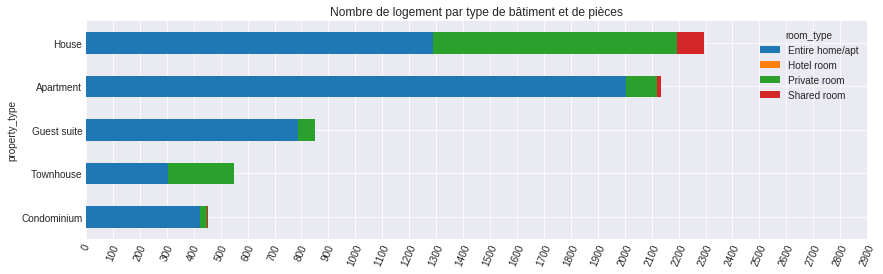

In [64]:
prop.plot(kind="barh", stacked=True)
plt.xticks(np.arange(0,3000,100), rotation=67)
plt.grid()
plt.title("Nombre de logement par type de bâtiment et de pièces")
plt.show()

### 3. Accommodates

Voici les données qui vont être visualisées :

In [42]:
accom = listingss.groupby(listingss.accommodates).accommodates.count()
accom.head()

accommodates
1     349
2    2669
3     720
4    1568
5     335
Name: accommodates, dtype: int64

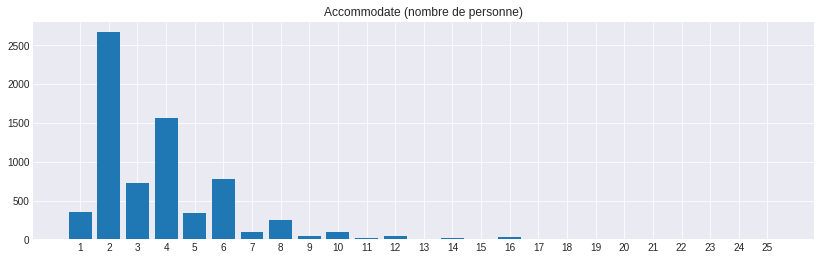

In [45]:
plt.bar(accom.index, accom)
plt.grid(which="major")
plt.grid(which="minor")
plt.xticks(ticks=np.arange(1,accom.index.max()+1))
plt.title("Accommodate (nombre de personne)")
plt.show()

### 4. Average daily price by neighbourhood_cleansed

Nous avons besoin de calculer le prix moyen par neighbourhood_cleansed. Le prix moyen par logement est déjà présent dans le dataset listings.

In [12]:
listingss.price

0       $296.00
1        $90.00
2        $62.00
3       $165.00
4       $125.00
         ...   
7012     $24.00
7013    $180.00
7014    $149.00
7015    $142.00
7016     $80.00
Name: price, Length: 7017, dtype: object

In [13]:
def format_price(column):
    return column.str.replace("$","").str.replace(",","").astype(float)

In [75]:
listings["price"]=format_price(listings.price)

In [76]:
(listings.price==0).sum()

2

Deux logements on un prix à zéro. Nous allons les supprimer pour dans le cadre de cette visualisation.

In [77]:
df_nozero = listings[listings.price!=0]

In [78]:
price_means = df_nozero.groupby("neighbourhood_cleansed").price.mean().sort_values(ascending=True)

In [12]:
#plt.xticks(np.arange(0,price_means.max()+20,20))
#plt.figure(figsize=(22,18))
#plt.barh(price_means.index, price_means)
#plt.grid()
#plt.title("Le prix moyen de logemnt par quartier")
#plt.show()

In [80]:
price_means_g = df_nozero.groupby("neighbourhood_group_cleansed").price.mean().sort_values(ascending=True)

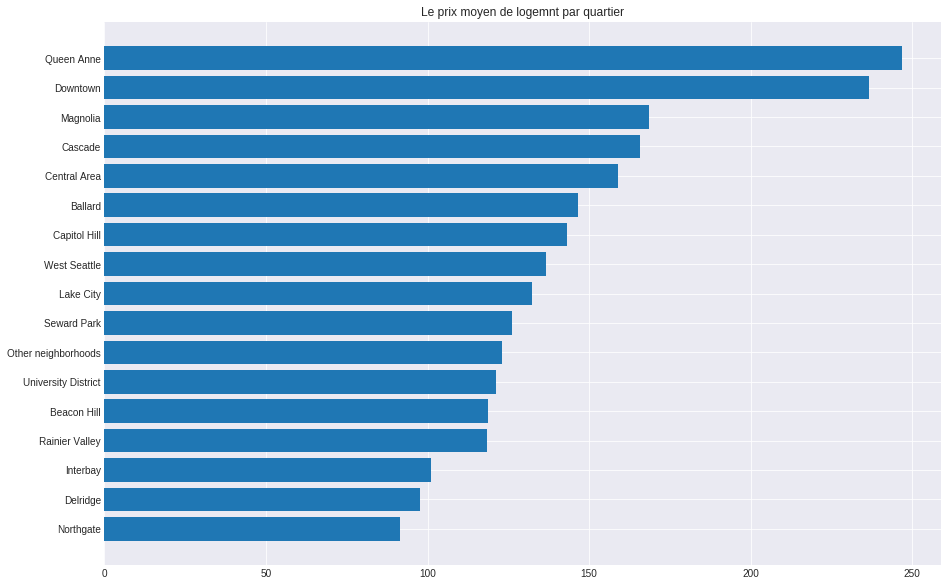

In [81]:
#plt.xticks(np.arange(0,price_means.max()+20,20))
plt.figure(figsize=(15,10))
plt.barh(price_means_g.index, price_means_g)
plt.grid()
plt.title("Le prix moyen de logemnt par quartier")
plt.show()

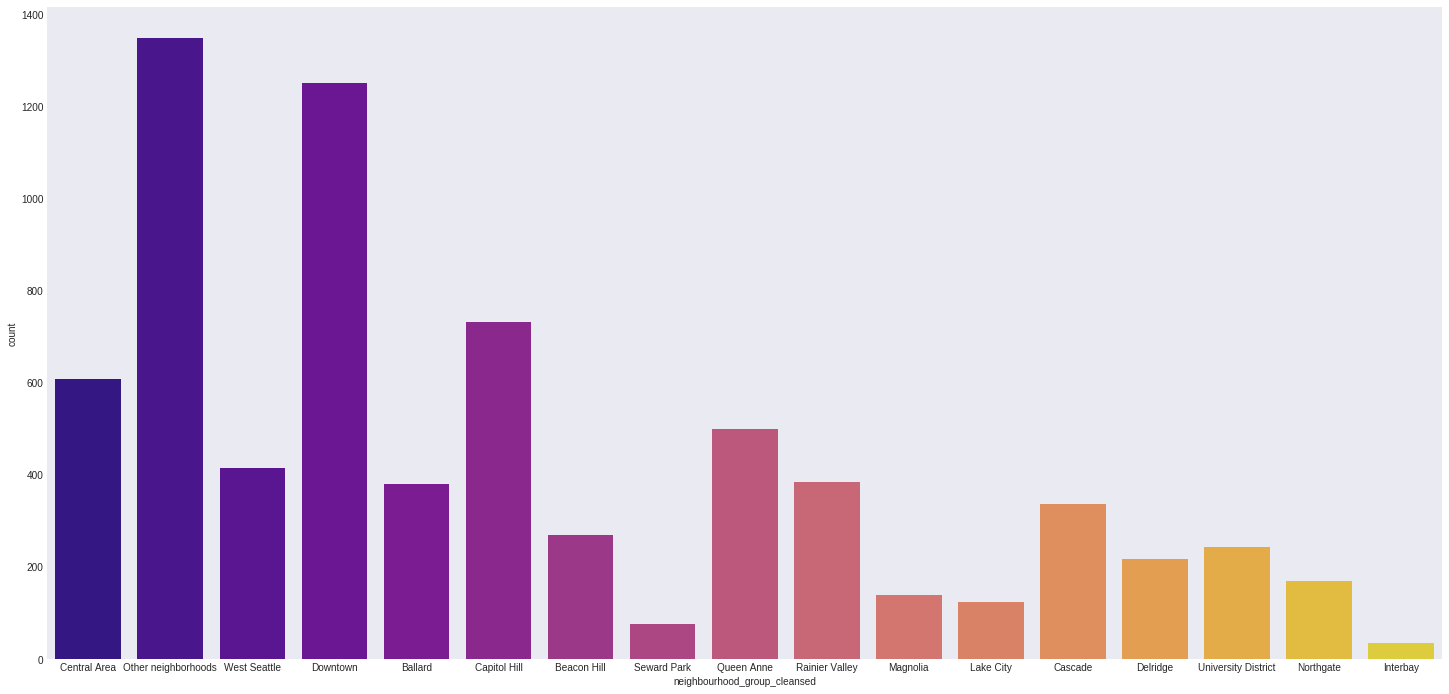

In [83]:
plt.figure(figsize=(25,12))
ax = sns.countplot(listings["neighbourhood_group_cleansed"], palette="plasma" )

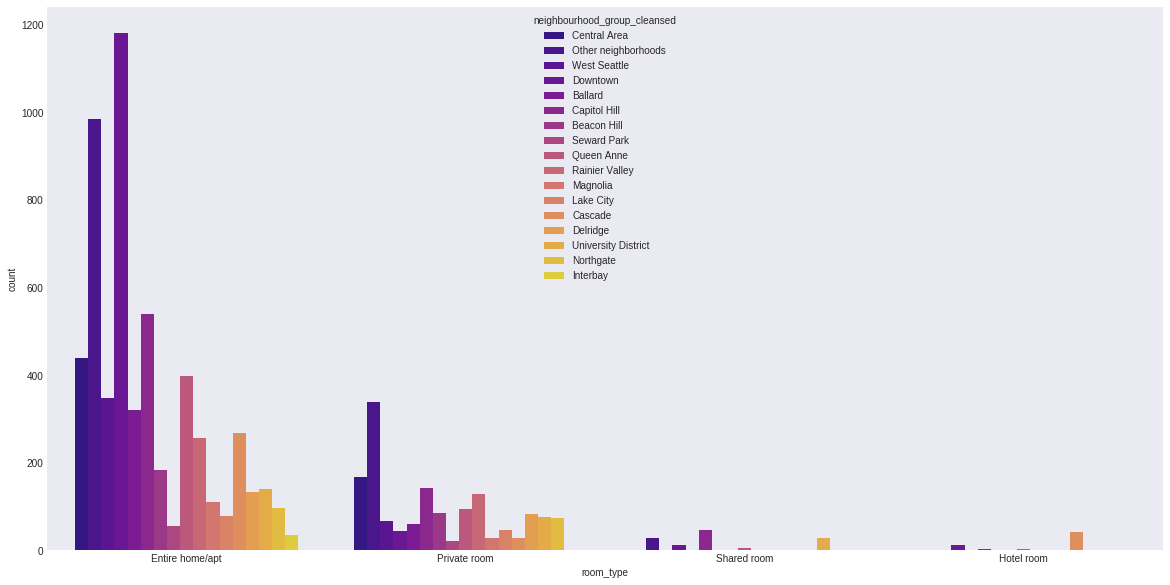

In [85]:
plt.figure(figsize=(20,10))
ax = sns.countplot(listings['room_type'],hue=listings['neighbourhood_group_cleansed'], palette='plasma')

### 5. Geographic representation of the number of hostings

In [4]:
import folium
from folium.plugins import FastMarkerCluster
import os
import numpy as np
import folium
from folium import plugins


lats2020 = listingss['latitude'].tolist()
lons2020 = listingss['longitude'].tolist()
locations = np.array(list(zip(lats2020, lons2020)))

map1 = folium.Map(location=[47.6488, -122.3964], zoom_start=11)
map1

plugins.MarkerCluster(locations[0:5000]).add_to(map1)
map1

In [87]:
list(zip(lats2020, lons2020))[1:6]

[(47.654109999999996, -122.33761000000001),
 (47.55017, -122.31936999999999),
 (47.55539, -122.38474),
 (47.55624, -122.38598),
 (47.654790000000006, -122.33652)]

In [88]:
np.array(list(zip(lats2020, lons2020)))


array([[  47.61082, -122.29082],
       [  47.65411, -122.33761],
       [  47.55017, -122.31937],
       ...,
       [  47.60803, -122.34086],
       [  47.67179, -122.38769],
       [  47.52707, -122.35872]])

### 6.Geographic per neighbourhood representation

In [6]:
#geo= "/home/arcanum/projet_C_O/neighbourhoods.geojson" 
geo = gpd.read_file('/home/arcanum/projet_C_O/neighbourhoods.geojson', driver='GeoJSON')
count = listingss.groupby("neighbourhood_cleansed").id.count().sort_values(ascending=True)

In [7]:
count[1:9]

neighbourhood_cleansed
Holly Park        4
South Park        9
View Ridge       13
Roxhill          13
Olympic Hills    14
Meadowbrook      17
Madison Park     18
Windermere       19
Name: id, dtype: int64

In [8]:
zonesmap=folium.Map(location=[47.6488, -122.3964], zoom_start=11)
folium.Choropleth(geo_data=geo,
                  data=count, fill_color='YlOrBr',smooth_factor=0.2,
                  name="Nombre de listing par arrondissement",highlight=True,
                 fill_opacity=0.5, line_opacity=1,line_weight = 0.2, 
                  #key_on="properties.nhood", 
                  legend_name='Nombre de listing').add_to(zonesmap)
zonesmap

lats2020 = listingss['latitude'].tolist()
lons2020 = listingss['longitude'].tolist()
locations = np.array(list(zip(lats2020, lons2020)))

map1 = folium.Map(location=[47.6488, -122.3964], zoom_start=11)
map1

plugins.MarkerCluster(locations[0:5000]).add_to(zonesmap)
zonesmap

### 7. Listings by date

In [9]:
planning.head()

listing_id        date available    price adjusted_price  minimum_nights  \
0        2318  2020-05-21         f  $243.00        $243.00               1   
1      708774  2020-05-21         f  $105.00        $105.00              30   
2      708774  2020-05-22         f  $120.00        $120.00              30   
3      708774  2020-05-23         f  $120.00        $120.00              30   
4      708774  2020-05-24         f  $105.00        $105.00              30   

   maximum_nights  
0            1125  
1            1125  
2            1125  
3            1125  
4            1125

In [14]:
planning["price"]=format_price(planning.price)

In [15]:
bydate = planning.groupby("date").available.apply(lambda x:(x=="t").sum())
bydate.index=pd.to_datetime(bydate.index)

In [16]:
bydate

date
2020-05-21    1442
2020-05-22    2063
2020-05-23    2281
2020-05-24    2446
2020-05-25    2554
              ... 
2021-05-20    2018
2021-05-21       2
2021-05-22       2
2021-05-23       2
2021-05-24       2
Name: available, Length: 369, dtype: int64

In [27]:
plt.figure(figsize=(20,8))
plt.plot(bydate, color="orange")
ax=plt.gca()
ax.xaxis.set_major_locator(pltdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%B %Y'))
plt.xlabel("Date")
plt.ylabel("Nombre de logement disponibles")
plt.title("Nombre de logements disponibles chaque nuit")
plt.grid()

### 8. Daily price for 2-persons accommodations

In [98]:
# planning

In [67]:
# df

In [7]:
accom2mean = planning.loc[:,["listing_id", "date", "price"]]
acco2mean = accom2mean.rename(columns={"listing_id": "id"})
acco2mean

id        date    price
0            2318  2020-05-21  $243.00
1          708774  2020-05-21  $105.00
2          708774  2020-05-22  $120.00
3          708774  2020-05-23  $120.00
4          708774  2020-05-24  $105.00
...           ...         ...      ...
2561200  43438074  2021-05-16   $25.00
2561201  43438074  2021-05-17   $25.00
2561202  43438074  2021-05-18   $25.00
2561203  43438074  2021-05-19   $25.00
2561204  43438074  2021-05-20   $25.00

[2561205 rows x 3 columns]

In [28]:
df_ = listingss[["id","accommodates"]]

In [29]:
df_1 = df_[df_["accommodates"]==2]
df_1

id  accommodates
1         6606             2
2         9419             2
8        14386             2
10       17951             2
12       20927             2
...        ...           ...
7006  43452587             2
7007  43452644             2
7008  43452684             2
7010  43453800             2
7012  43458946             2

[2669 rows x 2 columns]

In [30]:
planning.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [31]:
pl2 = planning[["listing_id", "price", "date"]]
pl2

listing_id  price        date
0              2318  243.0  2020-05-21
1            708774  105.0  2020-05-21
2            708774  120.0  2020-05-22
3            708774  120.0  2020-05-23
4            708774  105.0  2020-05-24
...             ...    ...         ...
2561200    43438074   25.0  2021-05-16
2561201    43438074   25.0  2021-05-17
2561202    43438074   25.0  2021-05-18
2561203    43438074   25.0  2021-05-19
2561204    43438074   25.0  2021-05-20

[2561205 rows x 3 columns]

In [33]:
pd.concat([listingss, planning], axis= 1)

id                        listing_url     scrape_id last_scraped  \
0        2318.0  https://www.airbnb.com/rooms/2318  2.020052e+13   2020-05-21   
1        6606.0  https://www.airbnb.com/rooms/6606  2.020052e+13   2020-05-21   
2        9419.0  https://www.airbnb.com/rooms/9419  2.020052e+13   2020-05-21   
3        9531.0  https://www.airbnb.com/rooms/9531  2.020052e+13   2020-05-21   
4        9534.0  https://www.airbnb.com/rooms/9534  2.020052e+13   2020-05-21   
...         ...                                ...           ...          ...   
2561200     NaN                                NaN           NaN          NaN   
2561201     NaN                                NaN           NaN          NaN   
2561202     NaN                                NaN           NaN          NaN   
2561203     NaN                                NaN           NaN          NaN   
2561204     NaN                                NaN           NaN          NaN   

                                                      name  \
0        Casa Madrona - Urban Oasis 1 block from the park!   
1                      Fab, private seattle urban cottage!   
2                      Glorious sun room w/ memory foambed   
3                      The Adorable Sweet Orange Craftsman   
4                         The Coolest Tangerine Dream MIL!   
...                                                    ...   
2561200                                                NaN   
2561201                                                NaN   
2561202                                                NaN   
2561203                                                NaN   
2561204                                                NaN   

                                                   summary  \
0        Gorgeous, architect remodeled, Dutch Colonial ...   
1        This tiny cottage is only 15x10, but it has ev...   
2        This beautiful double room features a magical ...   
3        The Sweet Orange is a delightful and spacious ...   
4        Welcome to my delicious Tangerine Dream!  A co...   
...                                                    ...   
2561200                                                NaN   
2561201                                                NaN   
2561202                                                NaN   
2561203                                                NaN   
2561204                                                NaN   

                                                     space  \
0        This beautiful, gracious home has been complet...   
1        Soo centrally located, this is a little house ...   
2        Our new Sunny space has a private room from th...   
3        The Sweet Orange invites you to stay and play,...   
4        The Tangerine Dream is a delightful, cozy moth...   
...                                                    ...   
2561200                                                NaN   
2561201                                                NaN   
2561202                                                NaN   
2561203                                                NaN   
2561204                                                NaN   

                                               description  \
0        Gorgeous, architect remodeled, Dutch Colonial ...   
1        This tiny cottage is only 15x10, but it has ev...   
2        This beautiful double room features a magical ...   
3        The Sweet Orange is a delightful and spacious ...   
4        Welcome to my delicious Tangerine Dream!  A co...   
...                                                    ...   
2561200                                                NaN   
2561201                                                NaN   
2561202                                                NaN   
2561203                                                NaN   
2561204                                                NaN   

        experiences_offered  \
0                      none  

In [ ]:
# result['date']= pd.to_datetime(result['date'])

In [34]:
#### Jointure planning et df en vue d'avoir l'information accomodate

join = pd.merge(pl2, df_1, left_on='listing_id', right_on='id', how='left')
join

listing_id  price        date          id  accommodates
0              2318  243.0  2020-05-21         NaN           NaN
1            708774  105.0  2020-05-21         NaN           NaN
2            708774  120.0  2020-05-22         NaN           NaN
3            708774  120.0  2020-05-23         NaN           NaN
4            708774  105.0  2020-05-24         NaN           NaN
...             ...    ...         ...         ...           ...
2561200    43438074   25.0  2021-05-16  43438074.0           2.0
2561201    43438074   25.0  2021-05-17  43438074.0           2.0
2561202    43438074   25.0  2021-05-18  43438074.0           2.0
2561203    43438074   25.0  2021-05-19  43438074.0           2.0
2561204    43438074   25.0  2021-05-20  43438074.0           2.0

[2561205 rows x 5 columns]

In [35]:
#### Condition sur accomodate et group by par date

agg = join.groupby("date").price.mean().sort_values(ascending = True)
agg.index = pd.to_datetime(agg.index)
agg.sort_index(inplace = True)#### Très important de trier par index

In [36]:
agg.drop_duplicates()

date
2020-05-21    139.350927
2020-05-22    147.973752
2020-05-23    148.970756
2020-05-24    145.777318
2020-05-25    142.587858
                 ...    
2021-05-18    167.180419
2021-05-19    167.064985
2021-05-20    167.442354
2021-05-21    111.571429
2021-05-23    108.000000
Name: price, Length: 367, dtype: float64

In [37]:
plt.plot(agg)

In [39]:
#### Prix des listings
plt.figure(figsize=(20,8))
plt.plot(agg, color="orange")
ax=plt.gca()
ax.xaxis.set_major_locator(pltdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%B %Y'))
plt.xlabel("Date")
plt.ylabel("Nombre de logement disponibles")
plt.title("Nombre de logements disponibles pour 2 personnes chaque nuit")
plt.grid()